In [2]:
%matplotlib inline
import numpy as np
import time
import torch
from torch import nn,optim
import sys
sys.path.append("..")
import d2lzh_pytorch as d2l

In [3]:
# 读取数据

def get_data_ch7():
    data = np.genfromtxt('D:\\新桌面\\machine_learning\\airfoil_self_noise.dat',delimiter='\t')
    # 使用标准化对数据进行预处理
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), \
    torch.tensor(data[:1500, -1], dtype=torch.float32) 

features, labels = get_data_ch7()
print(features.shape)
print(labels.shape)

torch.Size([1500, 5])
torch.Size([1500])


In [8]:
# 定义随机梯度下降

def sgd(params, states, hyperparams):
    for p in params:
        p.data -= hyperparams['lr'] * p.grad.data

In [10]:
# 训练函数
# 初始化一个线性回归模型，并使用小批量随机梯度下降

def train_ch7(optimizer_fn, states, hyperparams, features, labels, batch_size=10, num_epochs=2):
    # 初始化模型
    net, loss = d2l.linreg, d2l.squared_loss
    
    w = torch.nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size=(features.shape[1], 1)), dtype=torch.float32),requires_grad=True)
    b = torch.nn.Parameter(torch.zeros(1, dtype=torch.float32), requires_grad=True)
    
    def eval_loss():
        return loss(net(features, w, b), labels).mean().item()
    
    ls = [eval_loss()]
    
    data_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)
    
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X,y) in enumerate(data_iter):
            # 对各个小批量样本的损失函数求平均
            l = loss(net(X,w,b), y).mean()
            
            # 梯度清零
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
                
            l.backward()
            # 迭代模型参数
            optimizer_fn([w,b], states, hyperparams)
            if(batch_i + 1) * batch_size % 100 == 0:
                # 每100个样本记录下当前的训练误差
                ls.append(eval_loss())
                
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time()-start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

loss: 0.247789, 0.025008 sec per epoch


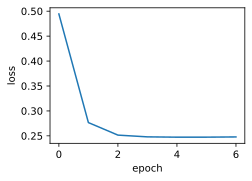

In [13]:
# 当批量大小为1500时，优化使用的是梯度下降

def train_sgd(lr, batch_size, num_epochs=2):
    train_ch7(sgd, None, {'lr':lr}, features, labels, batch_size, num_epochs)

train_sgd(1, 1500, 6)

loss: 0.242891, 1.251095 sec per epoch


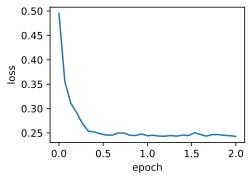

In [14]:
# 当批量大小为1时，优化使用的是随机梯度下降

train_sgd(0.005, 1)

loss: 0.243728, 0.091014 sec per epoch


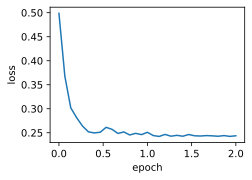

In [15]:
# 设置批量大小为10,优化使用小批量随机梯度下降

train_sgd(0.05, 10)

In [16]:
# 简洁实现

In [20]:
def train_pytorch_ch7(optimizer_fn, optimizer_hyperparams, features, labels,
                    batch_size=10, num_epochs=2):
    # 初始化模型
    net = nn.Sequential(
        nn.Linear(features.shape[-1], 1)
    )
    loss = nn.MSELoss()
    optimizer = optimizer_fn(net.parameters(), **optimizer_hyperparams)

    def eval_loss():
        return loss(net(features).view(-1), labels).item() / 2

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)

    for _ in range(num_epochs):
        start = time.time()
        
        for batch_i, (X, y) in enumerate(data_iter):
            # 除以2是为了和train_ch7保持一致, 因为squared_loss中除了2
            l = loss(net(X).view(-1), y) / 2 

            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
                
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

loss: 0.251207, 0.097009 sec per epoch


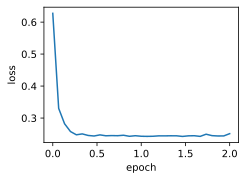

In [21]:
train_pytorch_ch7(optim.SGD, {"lr": 0.05}, features, labels, 10)